In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union, Tuple, Optional, Dict, Any
import json


# =============================================================================
# CORE GEOMETRIC FUNCTIONS
# =============================================================================

def create_point(x: float, y: float) -> Dict[str, float]:
    """Create a 2D point in meters"""
    return {"x": x, "y": y}


def create_line_segment(start: Dict[str, float], end: Dict[str, float]) -> Dict[str, Any]:
    """Create a line segment"""
    return {
        "type": "line",
        "start": start,
        "end": end
    }


def create_arc_segment(start: Dict[str, float], end: Dict[str, float],
                      center: Dict[str, float], clockwise: bool = True) -> Dict[str, Any]:
    """Create an arc segment"""
    return {
        "type": "arc",
        "start": start,
        "end": end,
        "center": center,
        "clockwise": clockwise
    }


def create_curve(elements: List[Dict[str, Any]], curve_type: str, name: str = None) -> Dict[str, Any]:
    """Create a curve from elements
    Args:
        elements: List of line/arc segments
        curve_type: "open" or "closed"
        name: Optional curve name
    """
    curve = {
        "elements": elements,
        "curve_type": curve_type,
        "name": name
    }

    # Validate curve continuity
    validate_curve(curve)
    return curve


def create_curve_array(curves: List[Dict[str, Any]], name: str = None) -> Dict[str, Any]:
    """Create an array of curves"""
    return {
        "curves": curves,
        "name": name
    }


# =============================================================================
# GEOMETRIC CALCULATIONS
# =============================================================================

def point_distance(p1: Dict[str, float], p2: Dict[str, float]) -> float:
    """Calculate distance between two points"""
    dx = p2["x"] - p1["x"]
    dy = p2["y"] - p1["y"]
    return np.sqrt(dx**2 + dy**2)


def line_length(line: Dict[str, Any]) -> float:
    """Calculate line segment length"""
    return point_distance(line["start"], line["end"])


def arc_radius(arc: Dict[str, Any]) -> float:
    """Calculate arc radius"""
    return point_distance(arc["start"], arc["center"])


def arc_angle(arc: Dict[str, Any]) -> float:
    """Calculate arc angle in radians"""
    center = arc["center"]
    start_angle = np.arctan2(arc["start"]["y"] - center["y"], arc["start"]["x"] - center["x"])
    end_angle = np.arctan2(arc["end"]["y"] - center["y"], arc["end"]["x"] - center["x"])

    angle = end_angle - start_angle
    if arc["clockwise"] and angle > 0:
        angle -= 2 * np.pi
    elif not arc["clockwise"] and angle < 0:
        angle += 2 * np.pi

    return abs(angle)


def arc_length(arc: Dict[str, Any]) -> float:
    """Calculate arc length"""
    return arc_radius(arc) * arc_angle(arc)


def element_length(element: Dict[str, Any]) -> float:
    """Calculate length of any element (line or arc)"""
    if element["type"] == "line":
        return line_length(element)
    elif element["type"] == "arc":
        return arc_length(element)
    else:
        raise ValueError(f"Unknown element type: {element['type']}")


def curve_length(curve: Dict[str, Any]) -> float:
    """Calculate total curve length"""
    return sum(element_length(elem) for elem in curve["elements"])


def curve_array_length(curve_array: Dict[str, Any]) -> float:
    """Calculate total length of all curves in array"""
    return sum(curve_length(curve) for curve in curve_array["curves"])


# =============================================================================
# VALIDATION
# =============================================================================

def validate_curve(curve: Dict[str, Any], tolerance: float = 1e-6) -> bool:
    """Validate curve continuity and closure"""
    elements = curve["elements"]

    if len(elements) > 1:
        for i in range(len(elements) - 1):
            current_end = elements[i]["end"]
            next_start = elements[i + 1]["start"]
            if point_distance(current_end, next_start) > tolerance:
                raise ValueError(f"Curve discontinuity between element {i} and {i+1}")

    # Check closure for closed curves
    if curve["curve_type"] == "closed" and len(elements) > 0:
        first_start = elements[0]["start"]
        last_end = elements[-1]["end"]
        if point_distance(first_start, last_end) > tolerance:
            raise ValueError("Closed curve is not properly closed")

    return True



In [16]:
# =============================================================================
# CURVE FACTORIES
# =============================================================================

def create_rectangle(width: float, height: float, origin: Dict[str, float] = None,
                    name: str = None) -> Dict[str, Any]:
    """Create a rectangular closed curve"""
    if origin is None:
        origin = create_point(0, 0)

    p1 = origin
    p2 = create_point(origin["x"] + width, origin["y"])
    p3 = create_point(origin["x"] + width, origin["y"] + height)
    p4 = create_point(origin["x"], origin["y"] + height)

    elements = [
        create_line_segment(p1, p2),
        create_line_segment(p2, p3),
        create_line_segment(p3, p4),
        create_line_segment(p4, p1)
    ]

    return create_curve(elements, "closed", name)


def create_trapezoid(bottom_width: float, top_width: float, height: float,
                    origin: Dict[str, float] = None, name: str = None) -> Dict[str, Any]:
    """Create a trapezoidal closed curve"""
    if origin is None:
        origin = create_point(0, 0)

    # Calculate offset for centering top width over bottom width
    offset = (bottom_width - top_width) / 2

    p1 = origin  # Bottom left
    p2 = create_point(origin["x"] + bottom_width, origin["y"])  # Bottom right
    p3 = create_point(origin["x"] + bottom_width - offset, origin["y"] + height)  # Top right
    p4 = create_point(origin["x"] + offset, origin["y"] + height)  # Top left

    elements = [
        create_line_segment(p1, p2),
        create_line_segment(p2, p3),
        create_line_segment(p3, p4),
        create_line_segment(p4, p1)
    ]

    return create_curve(elements, "closed", name)


def create_polyline(points: List[Dict[str, float]], closed: bool = False,
                   name: str = None) -> Dict[str, Any]:
    """Create a polyline from a list of points"""
    if len(points) < 2:
        raise ValueError("Need at least 2 points for a polyline")

    elements = []
    for i in range(len(points) - 1):
        elements.append(create_line_segment(points[i], points[i + 1]))

    # Close the curve if requested
    if closed:
        elements.append(create_line_segment(points[-1], points[0]))
        curve_type = "closed"
    else:
        curve_type = "open"

    return create_curve(elements, curve_type, name)


def create_line(start: Dict[str, float], end: Dict[str, float], name: str = None) -> Dict[str, Any]:
    """Create a simple line curve"""
    line = create_line_segment(start, end)
    return create_curve([line], "open", name)


# =============================================================================
# CURVE ARRAY UTILITIES
# =============================================================================

def get_closed_curves(curve_array: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Get only closed curves from array"""
    return [curve for curve in curve_array["curves"] if curve["curve_type"] == "closed"]


def get_open_curves(curve_array: Dict[str, Any]) -> List[Dict[str, Any]]:
    """Get only open curves from array"""
    return [curve for curve in curve_array["curves"] if curve["curve_type"] == "open"]


def add_curve_to_array(curve_array: Dict[str, Any], curve: Dict[str, Any]) -> None:
    """Add a curve to an existing curve array"""
    curve_array["curves"].append(curve)


# =============================================================================
# SERIALIZATION
# =============================================================================

def curve_to_dict(curve: Dict[str, Any]) -> Dict[str, Any]:
    """Convert curve to dictionary with calculated properties"""
    return {
        "name": curve.get("name"),
        "curve_type": curve["curve_type"],
        "elements": curve["elements"],
        "total_length": curve_length(curve)
    }


def curve_array_to_dict(curve_array: Dict[str, Any]) -> Dict[str, Any]:
    """Convert curve array to dictionary with calculated properties"""
    return {
        "name": curve_array.get("name"),
        "curve_count": len(curve_array["curves"]),
        "total_length": curve_array_length(curve_array),
        "curves": [curve_to_dict(curve) for curve in curve_array["curves"]]
    }


def curve_to_json(curve: Dict[str, Any]) -> str:
    """Export curve as JSON"""
    return json.dumps(curve_to_dict(curve), indent=2)


def curve_array_to_json(curve_array: Dict[str, Any]) -> str:
    """Export curve array as JSON"""
    return json.dumps(curve_array_to_dict(curve_array), indent=2)


# =============================================================================
# BUILDING COMPONENT FACTORIES
# =============================================================================

def create_floor_profile_array(layers: List[Tuple[str, float]], width: float = 1.0) -> Dict[str, Any]:
    """Create a typical floor composition as curve array
    Args:
        layers: List of (material_name, thickness) tuples
        width: Width of the profile in meters
    """
    curves = []
    current_y = 0

    for material, thickness in layers:
        rect = create_rectangle(
            width=width,
            height=thickness,
            origin=create_point(0, current_y),
            name=material
        )
        curves.append(rect)
        current_y += thickness

    return create_curve_array(curves, "Floor Profile")


def create_trapezoidal_profile_array(profiles: List[Tuple[float, float, float]],
                                   spacing: float = 0.1) -> Dict[str, Any]:
    """Create an array of trapezoidal profiles
    Args:
        profiles: List of (bottom_width, top_width, height) tuples
        spacing: Horizontal spacing between profiles
    """
    curves = []
    current_x = 0

    for i, (bottom_width, top_width, height) in enumerate(profiles):
        trap = create_trapezoid(
            bottom_width=bottom_width,
            top_width=top_width,
            height=height,
            origin=create_point(current_x, 0),
            name=f"Trapezoid_{i+1}"
        )
        curves.append(trap)
        current_x += bottom_width + spacing

    return create_curve_array(curves, "Trapezoidal Profile Array")

def create_wave_profile(total_width: float, wave_width: float, bottom_width: float,
                       top_width: float, height: float, name: str = None) -> Dict[str, Any]:
    """Create a wave profile geometry like corrugated metal sheeting
    Args:
        total_width: Total width of the profile (875)
        wave_width: Width of one complete wave cycle (175)
        bottom_width: Width of flat bottom section (65)
        top_width: Width of flat top section (50)
        height: Height of the wave (44)
        name: Optional profile name
    """
    if name is None:
        name = "Wave Profile"

    # Calculate derived dimensions
    side_slope_width = (wave_width - bottom_width) / 2  # Width of each sloped section
    top_offset = (bottom_width - top_width) / 2  # Horizontal offset for top section

    # Calculate number of complete waves
    num_waves = int(total_width // wave_width)
    remainder = total_width % wave_width

    # Start at the middle of the top width and go right
    start_x = -top_width / 2
    current_x = start_x

    points = []

    # Generate points for each wave
    for wave in range(num_waves):
        wave_start_x = current_x

        # Start at top left of wave
        if wave == 0:
            points.append(create_point(current_x, height))

        # Top flat section
        current_x += top_width
        points.append(create_point(current_x, height))

        # Right descending slope
        current_x += side_slope_width - top_offset
        points.append(create_point(current_x, 0))

        # Bottom flat section
        current_x += bottom_width
        points.append(create_point(current_x, 0))

        # Left ascending slope (start of next wave)
        current_x += side_slope_width - top_offset
        points.append(create_point(current_x, height))

    # Handle remainder if total_width doesn't divide evenly by wave_width
    if remainder > 0 and num_waves > 0:
        # Add partial wave
        remaining = remainder
        if remaining >= top_width:
            current_x += top_width
            points.append(create_point(current_x, height))
            remaining -= top_width

        if remaining > 0:
            # Partial slope down
            slope_progress = min(remaining / (side_slope_width - top_offset), 1.0)
            slope_x = current_x + remaining
            slope_y = height * (1 - slope_progress)
            points.append(create_point(slope_x, slope_y))

    # Create the polyline
    return create_polyline(points, closed=False, name=name)



def create_closed_wave_profile(total_width: float, wave_width: float, bottom_width: float,
                              top_width: float, height: float, depth: float = None,
                              name: str = None) -> Dict[str, Any]:
    """Create a closed wave profile with optional depth (like concrete above corrugated deck)
    Args:
        total_width: Total width of the profile (875)
        wave_width: Width of one complete wave cycle (175)
        bottom_width: Width of flat bottom section (65)
        top_width: Width of flat top section (50)
        height: Height of the wave (44)
        depth: Total depth including concrete above (e.g., 150 for 44mm profile + 106mm concrete)
        name: Optional profile name
    """
    if name is None:
        name = "Closed Wave Profile"

    # Get the open wave profile for the corrugated shape
    open_profile = create_wave_profile(total_width, wave_width, bottom_width,
                                     top_width, height, name + "_open")

    # Get the points from the open profile
    corrugated_points = []
    for element in open_profile["elements"]:
        if not corrugated_points:  # First element
            corrugated_points.append(element["start"])
        corrugated_points.append(element["end"])

    if not corrugated_points:
        return create_polyline([], closed=True, name=name)

    # Build the closed profile points
    points = []

    if depth is not None and depth > height:
        # Create profile with concrete depth above
        first_point = corrugated_points[0]
        last_point = corrugated_points[-1]

        # Start at top-left of concrete slab
        points.append(create_point(first_point["x"], depth))

        # Top edge of concrete slab (flat line)
        points.append(create_point(last_point["x"], depth))

        # Right edge down to corrugated profile
        points.append(create_point(last_point["x"], last_point["y"]))

        # Add corrugated profile points in reverse order (right to left)
        for point in reversed(corrugated_points):
            points.append(point)

        # Close back to start (left edge up to concrete)
        points.append(create_point(first_point["x"], first_point["y"]))

    else:
        # Original behavior - just close the corrugated profile at bottom
        points.extend(corrugated_points)

        # Add bottom closure
        last_point = points[-1]
        first_point = points[0]

        # Add point at same x as last point but at y=0
        if last_point["y"] != 0:
            points.append(create_point(last_point["x"], 0))

        # Add point at same x as first point but at y=0
        if first_point["y"] != 0:
            points.append(create_point(first_point["x"], 0))

    return create_polyline(points, closed=True, name=name)
# =============================================================================
# VISUALIZATION
# =============================================================================

class CurveViewer:
    """Matplotlib-based curve viewer"""

    def __init__(self, figure_size: Tuple[float, float] = (10, 8)):
        self.figure_size = figure_size

    def plot_curve(self, curve: Dict[str, Any], color: str = 'blue', linewidth: float = 2.0,
                   show_points: bool = False):
        """Plot a single curve"""
        fig, ax = plt.subplots(figsize=self.figure_size)
        self._draw_curve(ax, curve, color, linewidth, show_points)

        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')

        title = f"Curve: {curve.get('name', 'Unnamed')} ({curve['curve_type']})"
        title += f"\nLength: {curve_length(curve):.3f}m"
        ax.set_title(title)

        plt.tight_layout()
        plt.show()

    def plot_curve_array(self, curve_array: Dict[str, Any], colors: List[str] = None):
        """Plot an array of curves"""
        fig, ax = plt.subplots(figsize=self.figure_size)

        if colors is None:
            colors = plt.cm.tab10(np.linspace(0, 1, len(curve_array["curves"])))

        for i, curve in enumerate(curve_array["curves"]):
            color = colors[i % len(colors)]
            self._draw_curve(ax, curve, color, 2.0, False, label=curve.get("name", f"Curve {i+1}"))

        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('X (meters)')
        ax.set_ylabel('Y (meters)')
        ax.legend()

        title = f"Curve Array: {curve_array.get('name', 'Unnamed')}"
        title += f"\nTotal Length: {curve_array_length(curve_array):.3f}m"
        ax.set_title(title)

        plt.tight_layout()
        plt.show()

    def _draw_curve(self, ax, curve: Dict[str, Any], color: str, linewidth: float,
                   show_points: bool, label: str = None):
        """Internal method to draw a curve on given axes"""
        x_coords = []
        y_coords = []

        for element in curve["elements"]:
            if element["type"] == "line":
                # Add line segment points
                if not x_coords:  # First element
                    x_coords.extend([element["start"]["x"], element["end"]["x"]])
                    y_coords.extend([element["start"]["y"], element["end"]["y"]])
                else:
                    x_coords.append(element["end"]["x"])
                    y_coords.append(element["end"]["y"])

            elif element["type"] == "arc":
                # Tessellate arc for display
                n_points = max(10, int(arc_angle(element) * 20))

                center = element["center"]
                start_angle = np.arctan2(element["start"]["y"] - center["y"],
                                       element["start"]["x"] - center["x"])
                end_angle = np.arctan2(element["end"]["y"] - center["y"],
                                     element["end"]["x"] - center["x"])

                if element["clockwise"]:
                    if end_angle > start_angle:
                        end_angle -= 2 * np.pi
                    angles = np.linspace(start_angle, end_angle, n_points)
                else:
                    if end_angle < start_angle:
                        end_angle += 2 * np.pi
                    angles = np.linspace(start_angle, end_angle, n_points)

                radius = arc_radius(element)
                arc_x = center["x"] + radius * np.cos(angles)
                arc_y = center["y"] + radius * np.sin(angles)

                if not x_coords:  # First element
                    x_coords.extend(arc_x.tolist())
                    y_coords.extend(arc_y.tolist())
                else:
                    x_coords.extend(arc_x[1:].tolist())
                    y_coords.extend(arc_y[1:].tolist())

        # Plot the curve
        ax.plot(x_coords, y_coords, color=color, linewidth=linewidth, label=label)

        # Show control points if requested
        if show_points:
            all_points = []
            for element in curve["elements"]:
                all_points.extend([element["start"], element["end"]])
                if element["type"] == "arc":
                    all_points.append(element["center"])

            unique_points = []
            for point in all_points:
                if not any(point_distance(point, up) < 1e-6 for up in unique_points):
                    unique_points.append(point)

            for point in unique_points:
                ax.plot(point["x"], point["y"], 'ro', markersize=4)


class SVGCurveViewer:
    """SVG-based viewer that mirrors D3.js output more closely"""

    def __init__(self, width: int = 800, height: int = 600, margin: int = 50):
        self.width = width
        self.height = height
        self.margin = margin
        self.view_width = width - 2 * margin
        self.view_height = height - 2 * margin

    def plot_curve(self, curve: Dict[str, Any], stroke_color: str = '#2563eb',
                   stroke_width: float = 2.0, show_points: bool = False) -> str:
        """Generate SVG for a single curve"""
        bounds = self._calculate_bounds([curve])
        transform = self._create_transform(bounds)

        svg_paths = self._curve_to_svg_path(curve, transform)

        svg = self._create_svg_header()
        svg += f'  <g stroke="{stroke_color}" stroke-width="{stroke_width}" fill="none">\n'
        svg += f'    <path d="{svg_paths}" />\n'

        if show_points:
            svg += self._add_control_points(curve, transform, '#ef4444')

        svg += '  </g>\n'
        svg += self._add_grid(bounds, transform)

        name = curve.get('name', 'Curve')
        title = f"{name} ({curve['curve_type']}) - {curve_length(curve):.3f}m"
        svg += self._add_title(title)
        svg += '</svg>'

        return svg

    def plot_curve_array(self, curve_array: Dict[str, Any], colors: List[str] = None) -> str:
        """Generate SVG for an array of curves"""
        if colors is None:
            colors = ['#2563eb', '#dc2626', '#16a34a', '#ca8a04', '#9333ea', '#c2410c']

        bounds = self._calculate_bounds(curve_array["curves"])
        transform = self._create_transform(bounds)

        svg = self._create_svg_header()

        # Add each curve with different colors
        for i, curve in enumerate(curve_array["curves"]):
            color = colors[i % len(colors)]
            svg_path = self._curve_to_svg_path(curve, transform)
            svg += f'  <g stroke="{color}" stroke-width="2" fill="none">\n'
            svg += f'    <path d="{svg_path}" />\n'
            svg += '  </g>\n'

        svg += self._add_grid(bounds, transform)
        svg += self._add_legend(curve_array["curves"], colors)

        name = curve_array.get('name', 'Curve Array')
        title = f"{name} - Total: {curve_array_length(curve_array):.3f}m"
        svg += self._add_title(title)
        svg += '</svg>'

        return svg

    def _curve_to_svg_path(self, curve: Dict[str, Any], transform) -> str:
        """Convert curve to SVG path string (D3.js compatible)"""
        path_commands = []

        for i, element in enumerate(curve["elements"]):
            if element["type"] == "line":
                start_x, start_y = transform(element["start"]["x"], element["start"]["y"])
                end_x, end_y = transform(element["end"]["x"], element["end"]["y"])

                if i == 0:
                    path_commands.append(f"M {start_x:.2f} {start_y:.2f}")
                path_commands.append(f"L {end_x:.2f} {end_y:.2f}")

            elif element["type"] == "arc":
                start_x, start_y = transform(element["start"]["x"], element["start"]["y"])
                end_x, end_y = transform(element["end"]["x"], element["end"]["y"])

                if i == 0:
                    path_commands.append(f"M {start_x:.2f} {start_y:.2f}")

                # Calculate radius in transformed space
                radius = arc_radius(element) * transform.scale

                # SVG arc flags
                large_arc_flag = 1 if arc_angle(element) > np.pi else 0
                sweep_flag = 0 if element["clockwise"] else 1

                path_commands.append(f"A {radius:.2f} {radius:.2f} 0 {large_arc_flag} {sweep_flag} {end_x:.2f} {end_y:.2f}")

        # Close path if it's a closed curve
        if curve["curve_type"] == "closed":
            path_commands.append("Z")

        return " ".join(path_commands)

    def _calculate_bounds(self, curves: List[Dict[str, Any]]) -> dict:
        """Calculate bounding box for curves"""
        all_points = []

        for curve in curves:
            for element in curve["elements"]:
                all_points.extend([element["start"], element["end"]])
                if element["type"] == "arc":
                    # Add arc extremes for better bounds
                    center = element["center"]
                    radius = arc_radius(element)
                    all_points.extend([
                        create_point(center["x"] - radius, center["y"]),
                        create_point(center["x"] + radius, center["y"]),
                        create_point(center["x"], center["y"] - radius),
                        create_point(center["x"], center["y"] + radius)
                    ])

        if not all_points:
            return {"min_x": 0, "max_x": 1, "min_y": 0, "max_y": 1}

        xs = [p["x"] for p in all_points]
        ys = [p["y"] for p in all_points]

        return {
            "min_x": min(xs),
            "max_x": max(xs),
            "min_y": min(ys),
            "max_y": max(ys)
        }

    def _create_transform(self, bounds: dict):
        """Create coordinate transform function"""
        data_width = bounds["max_x"] - bounds["min_x"]
        data_height = bounds["max_y"] - bounds["min_y"]

        if data_width == 0:
            data_width = 1
        if data_height == 0:
            data_height = 1

        # Add 10% padding
        padding = 0.1
        data_width *= (1 + padding)
        data_height *= (1 + padding)

        scale_x = self.view_width / data_width
        scale_y = self.view_height / data_height
        scale = min(scale_x, scale_y)

        # Center the content
        center_x = (bounds["min_x"] + bounds["max_x"]) / 2
        center_y = (bounds["min_y"] + bounds["max_y"]) / 2

        offset_x = self.width / 2 - center_x * scale
        offset_y = self.height / 2 + center_y * scale

        def transform(x, y):
            svg_x = x * scale + offset_x
            svg_y = -y * scale + offset_y  # Flip Y axis
            return svg_x, svg_y

        transform.scale = scale
        return transform

    def _create_svg_header(self) -> str:
        return f'<svg width="{self.width}" height="{self.height}" xmlns="http://www.w3.org/2000/svg">\n'

    def _add_control_points(self, curve: Dict[str, Any], transform, color: str = '#ef4444') -> str:
        svg = f'  <g fill="{color}">\n'

        points_added = set()
        for element in curve["elements"]:
            for point in [element["start"], element["end"]]:
                point_key = (point["x"], point["y"])
                if point_key not in points_added:
                    x, y = transform(point["x"], point["y"])
                    svg += f'    <circle cx="{x:.1f}" cy="{y:.1f}" r="3" />\n'
                    points_added.add(point_key)

            if element["type"] == "arc":
                center = element["center"]
                center_key = (center["x"], center["y"])
                if center_key not in points_added:
                    x, y = transform(center["x"], center["y"])
                    svg += f'    <circle cx="{x:.1f}" cy="{y:.1f}" r="2" fill="#fbbf24" />\n'
                    points_added.add(center_key)

        svg += '  </g>\n'
        return svg

    def _add_grid(self, bounds: dict, transform) -> str:
        svg = '  <g stroke="#e5e7eb" stroke-width="0.5" opacity="0.5">\n'

        # Calculate grid spacing
        data_width = bounds["max_x"] - bounds["min_x"]
        data_height = bounds["max_y"] - bounds["min_y"]

        grid_step = max(data_width, data_height) / 10

        # Round to nice numbers
        magnitude = 10 ** np.floor(np.log10(grid_step))
        nice_step = magnitude * np.ceil(grid_step / magnitude)

        # Vertical grid lines
        start_x = np.floor(bounds["min_x"] / nice_step) * nice_step
        x = start_x
        while x <= bounds["max_x"]:
            x1, y1 = transform(x, bounds["min_y"])
            x2, y2 = transform(x, bounds["max_y"])
            svg += f'    <line x1="{x1:.1f}" y1="{y1:.1f}" x2="{x2:.1f}" y2="{y2:.1f}" />\n'
            x += nice_step

        # Horizontal grid lines
        start_y = np.floor(bounds["min_y"] / nice_step) * nice_step
        y = start_y
        while y <= bounds["max_y"]:
            x1, y1 = transform(bounds["min_x"], y)
            x2, y2 = transform(bounds["max_x"], y)
            svg += f'    <line x1="{x1:.1f}" y1="{y1:.1f}" x2="{x2:.1f}" y2="{y2:.1f}" />\n'
            y += nice_step

        svg += '  </g>\n'
        return svg

    def _add_legend(self, curves: List[Dict[str, Any]], colors: List[str]) -> str:
        svg = '  <g>\n'

        legend_x = 20
        legend_y = 30

        for i, curve in enumerate(curves[:6]):
            color = colors[i % len(colors)]
            y_pos = legend_y + i * 20

            # Color indicator
            svg += f'    <rect x="{legend_x}" y="{y_pos-8}" width="15" height="3" fill="{color}" />\n'

            # Label
            label = curve.get("name", f"Curve {i+1}")
            svg += f'    <text x="{legend_x + 25}" y="{y_pos}" font-family="Arial, sans-serif" font-size="12" fill="#374151">{label}</text>\n'

        svg += '  </g>\n'
        return svg

    def _add_title(self, title: str) -> str:
        return f'  <text x="{self.width//2}" y="25" font-family="Arial, sans-serif" font-size="16" font-weight="bold" text-anchor="middle" fill="#111827">{title}</text>\n'

    def display_in_jupyter(self, svg_content: str):
        """Display SVG in Jupyter notebook"""
        from IPython.display import SVG, display
        display(SVG(svg_content))


# =============================================================================
# UTILITY FUNCTIONS FOR D3.js INTEGRATION
# =============================================================================

def extract_svg_path_data(curve: Dict[str, Any], bounds: dict = None,
                         canvas_width: int = 800, canvas_height: int = 600) -> str:
    """Extract SVG path data string for D3.js use"""
    svg_viewer = SVGCurveViewer(canvas_width, canvas_height)

    if bounds is None:
        bounds = svg_viewer._calculate_bounds([curve])

    transform = svg_viewer._create_transform(bounds)
    return svg_viewer._curve_to_svg_path(curve, transform)


def get_curve_bounds(curves: List[Dict[str, Any]]) -> dict:
    """Get bounding box for a list of curves"""
    svg_viewer = SVGCurveViewer()
    return svg_viewer._calculate_bounds(curves)

In [3]:
# Demo script for the 2D Curve Generator (Dictionary-Based)
# Run this in Jupyter to test the functionality

# Create viewer instances
viewer = CurveViewer(figure_size=(12, 8))
svg_viewer = SVGCurveViewer(width=800, height=600)

# Example 1: Simple rectangle
print("=== Example 1: Rectangle ===")
rect = create_rectangle(width=3.0, height=2.0, name="Simple Rectangle")
print(f"Rectangle length: {curve_length(rect):.3f}m")
print(f"Rectangle is closed: {rect['curve_type'] == 'closed'}")

=== Example 1: Rectangle ===
Rectangle length: 10.000m
Rectangle is closed: True


=== Example 1: Rectangle ===
Rectangle length: 10.000m
Rectangle is closed: True
SVG version (D3.js compatible):


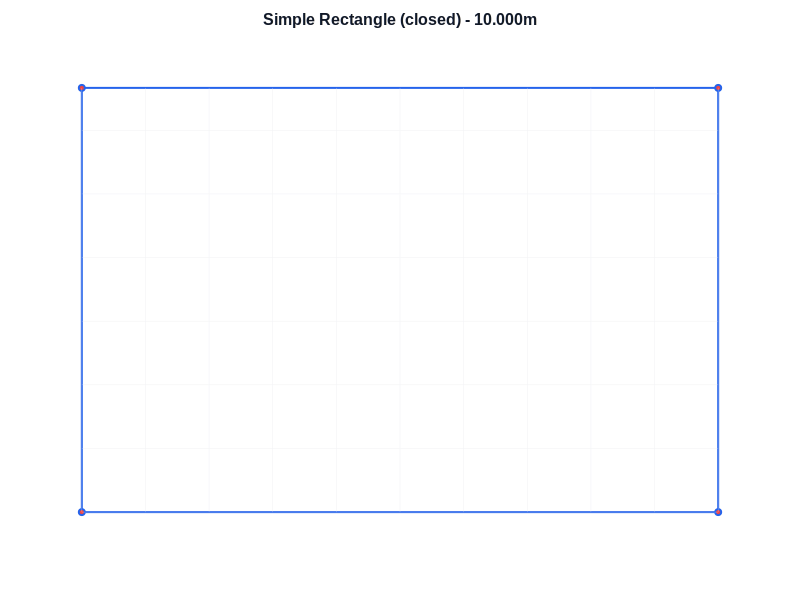

In [6]:
# Demo script for the 2D Curve Generator (Dictionary-Based)
# Run this in Jupyter to test the functionality

# Create viewer instances
svg_viewer = SVGCurveViewer(width=800, height=600)

# Example 1: Simple rectangle
print("=== Example 1: Rectangle ===")
rect = create_rectangle(width=3.0, height=2.0, name="Simple Rectangle")
print(f"Rectangle length: {curve_length(rect):.3f}m")
print(f"Rectangle is closed: {rect['curve_type'] == 'closed'}")

print("SVG version (D3.js compatible):")
svg_content = svg_viewer.plot_curve(rect, stroke_color='#2563eb', show_points=True)
svg_viewer.display_in_jupyter(svg_content)


=== Example 2: Trapezoid ===
Trapezoid length: 9.606m
Number of elements: 4
SVG version:


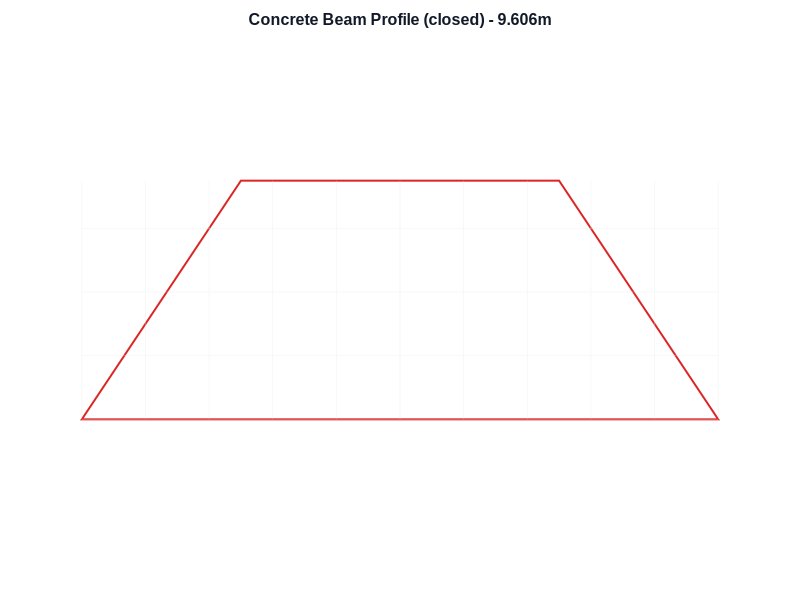

In [5]:
# Example 2: Trapezoid
print("\n=== Example 2: Trapezoid ===")
trap = create_trapezoid(
    bottom_width=4.0,
    top_width=2.0,
    height=1.5,
    name="Concrete Beam Profile"
)
print(f"Trapezoid length: {curve_length(trap):.3f}m")
print(f"Number of elements: {len(trap['elements'])}")

print("SVG version:")
svg_content = svg_viewer.plot_curve(trap, stroke_color='#dc2626')
svg_viewer.display_in_jupyter(svg_content)


=== Example 3: Open Polyline ===
Polyline length: 5.749m
Is open curve: True


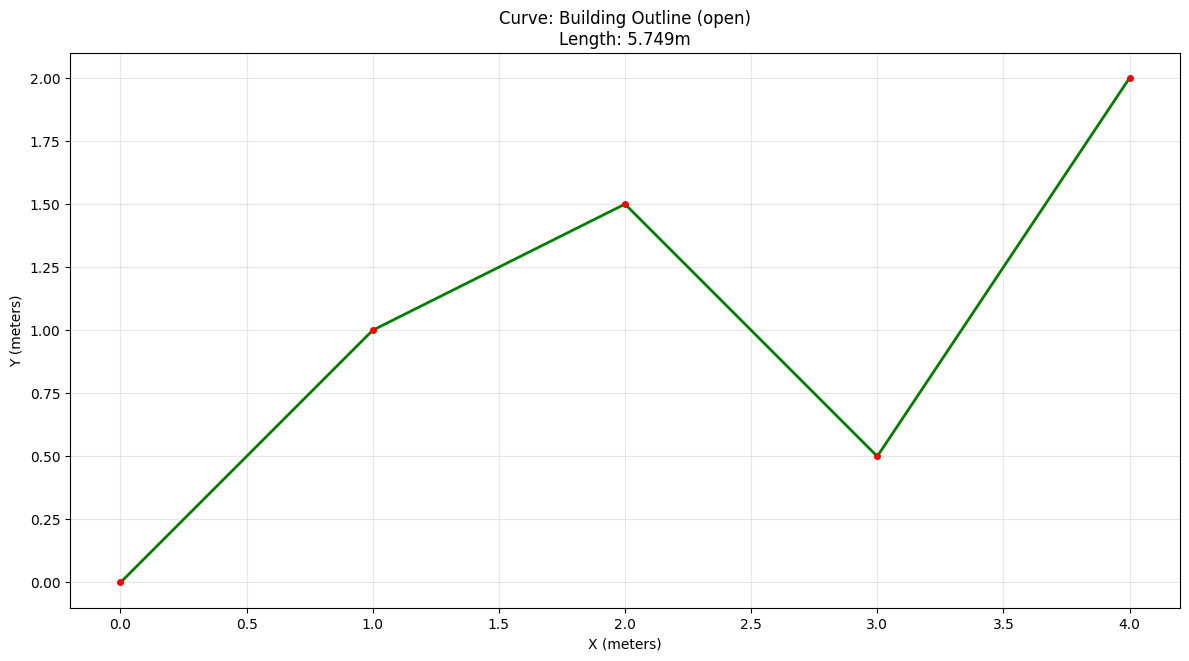

In [7]:
# Example 3: Polyline (open curve)
print("\n=== Example 3: Open Polyline ===")
points = [
    create_point(0, 0),
    create_point(1, 1),
    create_point(2, 1.5),
    create_point(3, 0.5),
    create_point(4, 2)
]
polyline = create_polyline(points, closed=False, name="Building Outline")
print(f"Polyline length: {curve_length(polyline):.3f}m")
print(f"Is open curve: {polyline['curve_type'] == 'open'}")

viewer.plot_curve(polyline, color='green', show_points=True)


=== Example 4: Floor Composition ===
Total floor thickness: 3.000m
Number of layers: 4
SVG version with legend:


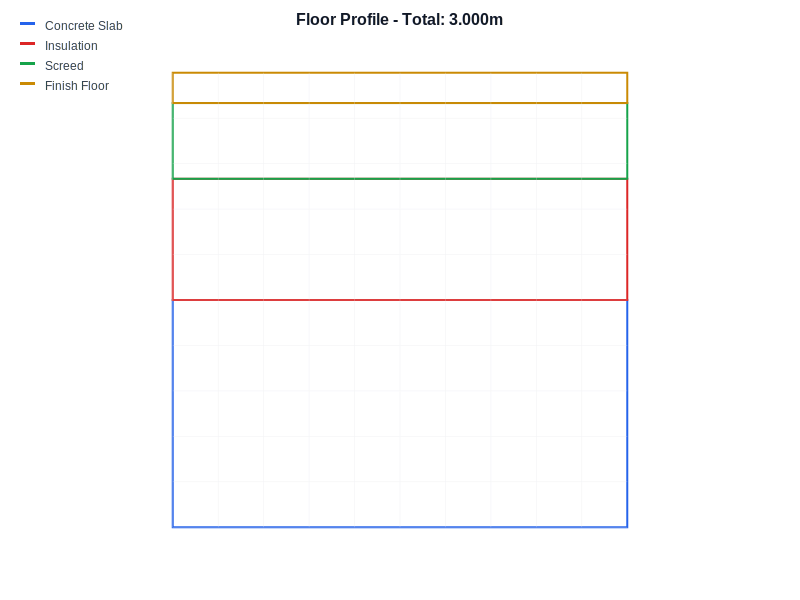

In [8]:
# Example 4: Floor composition array
print("\n=== Example 4: Floor Composition ===")
floor_layers = [
    ("Concrete Slab", 0.15),
    ("Insulation", 0.08),
    ("Screed", 0.05),
    ("Finish Floor", 0.02)
]
floor_profile = create_floor_profile_array(floor_layers, width=0.3)
print(f"Total floor thickness: {curve_array_length(floor_profile):.3f}m")
print(f"Number of layers: {len(floor_profile['curves'])}")

print("SVG version with legend:")
svg_content = svg_viewer.plot_curve_array(floor_profile)
svg_viewer.display_in_jupyter(svg_content)


=== Example 5: Trapezoidal Profile Array ===
Total array length: 6.485m


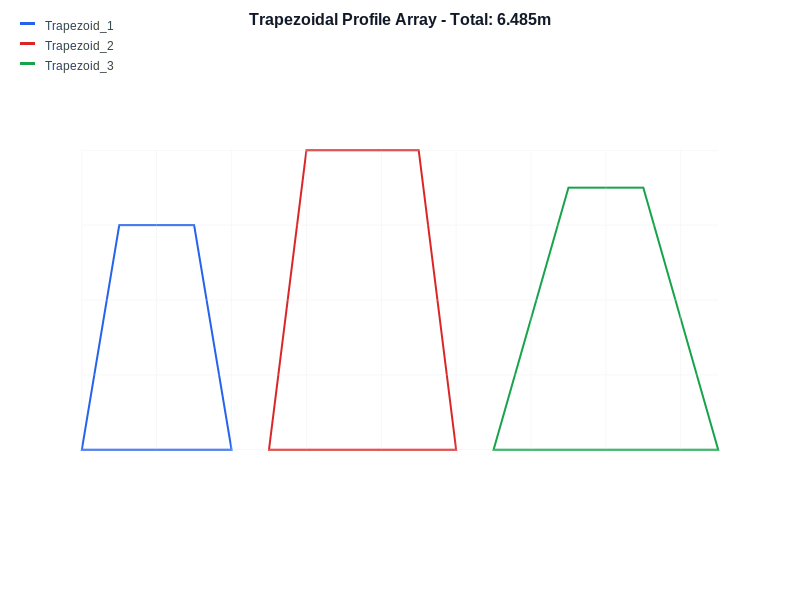

In [9]:
# Example 5: Trapezoidal profile array
print("\n=== Example 5: Trapezoidal Profile Array ===")
trap_profiles = [
    (0.4, 0.2, 0.6),  # bottom_width, top_width, height
    (0.5, 0.3, 0.8),
    (0.6, 0.2, 0.7),
]
trap_array = create_trapezoidal_profile_array(trap_profiles, spacing=0.1)
print(f"Total array length: {curve_array_length(trap_array):.3f}m")

svg_content = svg_viewer.plot_curve_array(trap_array)
svg_viewer.display_in_jupyter(svg_content)


=== Example 6: Mixed Profile Array ===
Mixed profile total length: 16.200m
Closed curves: 3
Open curves: 0


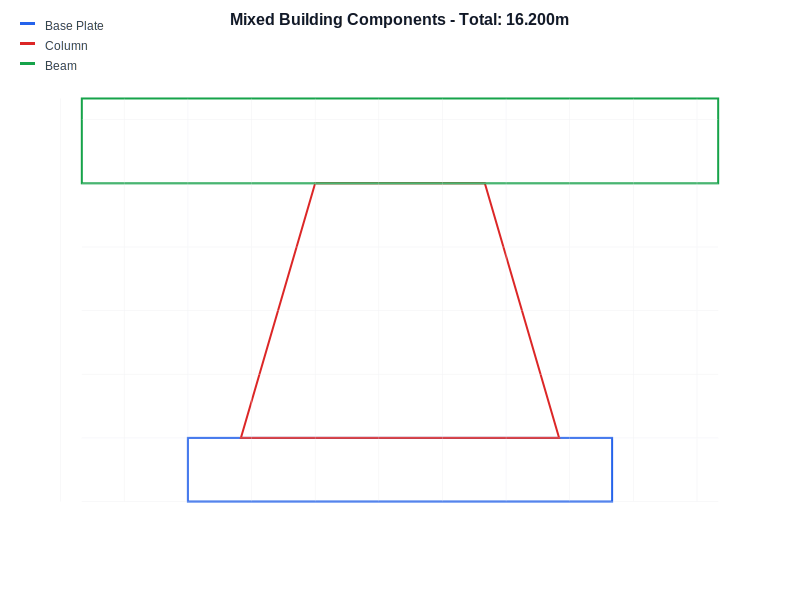

In [10]:
# Example 6: Mixed curve array
print("\n=== Example 6: Mixed Profile Array ===")
mixed_curves = create_curve_array([], name="Mixed Building Components")

# Add various profiles using the utility function
add_curve_to_array(mixed_curves, create_rectangle(2.0, 0.3, create_point(0, 0), "Base Plate"))
add_curve_to_array(mixed_curves, create_trapezoid(1.5, 0.8, 1.2, create_point(0.25, 0.3), "Column"))
add_curve_to_array(mixed_curves, create_rectangle(3.0, 0.4, create_point(-0.5, 1.5), "Beam"))

print(f"Mixed profile total length: {curve_array_length(mixed_curves):.3f}m")
print(f"Closed curves: {len(get_closed_curves(mixed_curves))}")
print(f"Open curves: {len(get_open_curves(mixed_curves))}")

svg_content = svg_viewer.plot_curve_array(mixed_curves)
svg_viewer.display_in_jupyter(svg_content)

In [11]:
# Example 7: JSON Export
print("\n=== Example 7: JSON Export ===")
sample_rect = create_rectangle(1.0, 0.5, name="Export Sample")
json_data = curve_to_json(sample_rect)
print("JSON export sample:")
print(json_data)


=== Example 7: JSON Export ===
JSON export sample:
{
  "name": "Export Sample",
  "curve_type": "closed",
  "elements": [
    {
      "type": "line",
      "start": {
        "x": 0,
        "y": 0
      },
      "end": {
        "x": 1.0,
        "y": 0
      }
    },
    {
      "type": "line",
      "start": {
        "x": 1.0,
        "y": 0
      },
      "end": {
        "x": 1.0,
        "y": 0.5
      }
    },
    {
      "type": "line",
      "start": {
        "x": 1.0,
        "y": 0.5
      },
      "end": {
        "x": 0,
        "y": 0.5
      }
    },
    {
      "type": "line",
      "start": {
        "x": 0,
        "y": 0.5
      },
      "end": {
        "x": 0,
        "y": 0
      }
    }
  ],
  "total_length": 3.0
}


In [12]:
# Example 8: D3.js Integration
print("\n=== Example 8: D3.js Path Data Extraction ===")
sample_curves = [
    create_rectangle(1.0, 0.5, create_point(0, 0), "Rect1"),
    create_trapezoid(1.2, 0.8, 0.6, create_point(1.5, 0), "Trap1")
]

# Get bounds for consistent scaling
bounds = get_curve_bounds(sample_curves)
print(f"Curves bounds: {bounds}")

# Extract D3.js-ready path data
for i, curve in enumerate(sample_curves):
    path_data = extract_svg_path_data(curve, bounds)
    print(f"\nCurve {i+1} ({curve.get('name')}) SVG path:")
    print(f'd="{path_data}"')

print("\n=== Functional Programming Benefits ===")
print("✓ Simple dictionaries - JSON ready")
print("✓ Pure functions - no side effects")
print("✓ Easy serialization/deserialization")
print("✓ Functional composition")
print("✓ Immutable data structures")


=== Example 8: D3.js Path Data Extraction ===
Curves bounds: {'min_x': 0, 'max_x': 2.7, 'min_y': 0, 'max_y': 0.6}

Curve 1 (Rect1) SVG path:
d="M 81.82 370.71 L 317.51 370.71 L 317.51 252.86 L 81.82 252.86 L 81.82 370.71 Z"

Curve 2 (Trap1) SVG path:
d="M 435.35 370.71 L 718.18 370.71 L 671.04 229.29 L 482.49 229.29 L 435.35 370.71 Z"

=== Functional Programming Benefits ===
✓ Simple dictionaries - JSON ready
✓ Pure functions - no side effects
✓ Easy serialization/deserialization
✓ Functional composition
✓ Immutable data structures



=== Example 9: Functional Composition ===
Building profile length: 29.249m
Foundation length: 11.000m
Wall length: 6.600m
Roof length: 11.649m


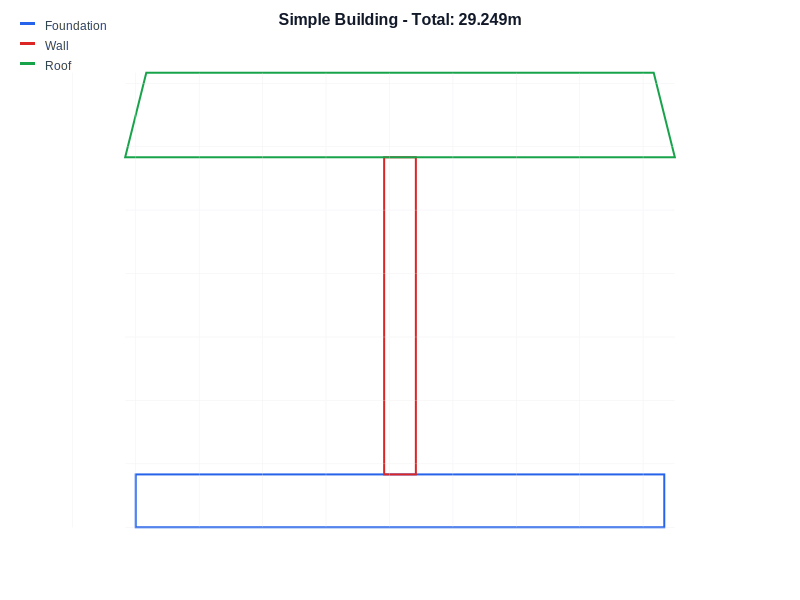

In [13]:
# Example 9: Functional composition
print("\n=== Example 9: Functional Composition ===")
# Create a building profile by composing functions
foundation = create_rectangle(5.0, 0.5, create_point(0, 0), "Foundation")
wall = create_rectangle(0.3, 3.0, create_point(2.35, 0.5), "Wall")
roof = create_trapezoid(5.2, 4.8, 0.8, create_point(-0.1, 3.5), "Roof")

building_profile = create_curve_array([foundation, wall, roof], "Simple Building")

print(f"Building profile length: {curve_array_length(building_profile):.3f}m")
print(f"Foundation length: {curve_length(foundation):.3f}m")
print(f"Wall length: {curve_length(wall):.3f}m")
print(f"Roof length: {curve_length(roof):.3f}m")

svg_content = svg_viewer.plot_curve_array(building_profile)
svg_viewer.display_in_jupyter(svg_content)


=== Example 10: Wave Profile Geometry ===
Wave profile length: 1222.476m
Number of elements: 20
Profile type: open

Open wave profile (cutting line):


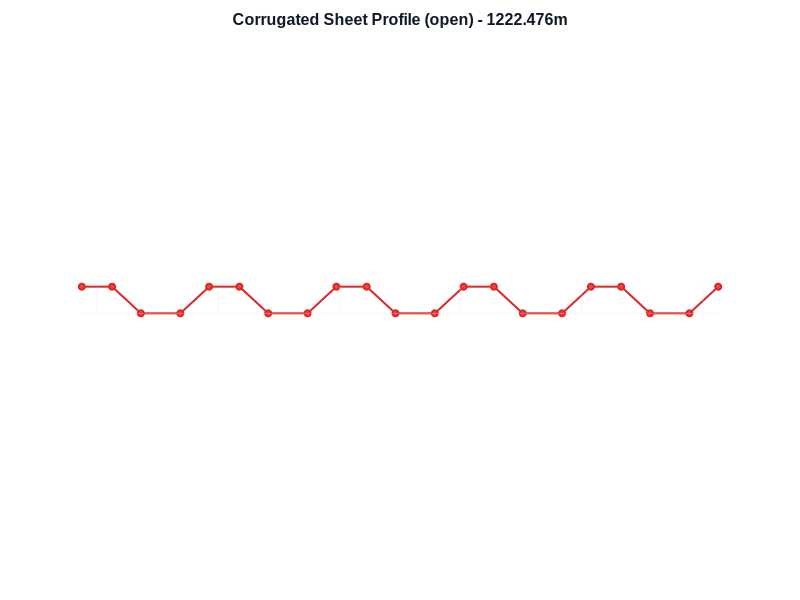


Closed wave profile length: 2310.524m
Profile type: closed
Closed wave profile (cross-section):


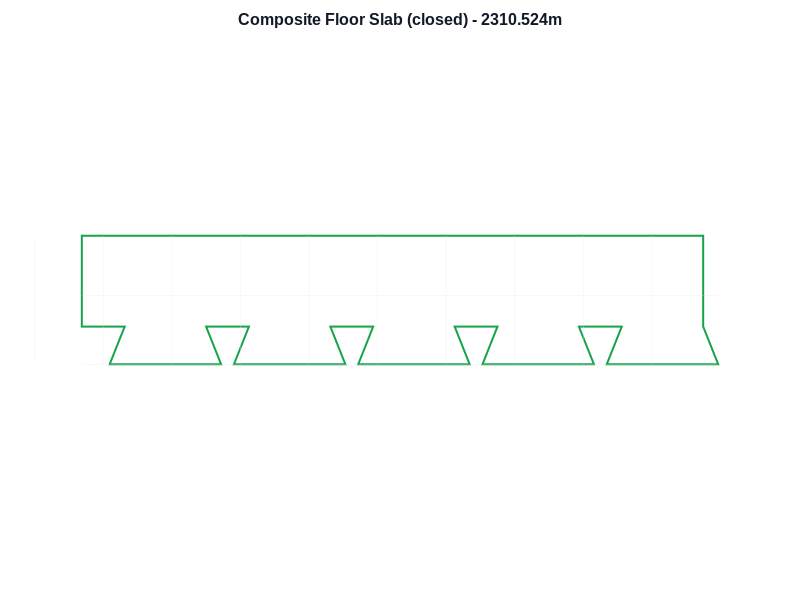

In [21]:
# Example 10: Wave Profile (Like your image)
print("\n=== Example 10: Wave Profile Geometry ===")
# Parameters from your image
total_width = 875    # Total width
wave_width = 175     # Width of one wave cycle
bottom_width = 65    # Width of flat bottom section
top_width = 50       # Width of flat top section
height = 44          # Height of the wave

# Create open wave profile (like a cutting line)
wave_profile = create_wave_profile(
    total_width=total_width,
    wave_width=wave_width,
    bottom_width=bottom_width,
    top_width=top_width,
    height=height,
    name="Corrugated Sheet Profile"
)

print(f"Wave profile length: {curve_length(wave_profile):.3f}m")
print(f"Number of elements: {len(wave_profile['elements'])}")
print(f"Profile type: {wave_profile['curve_type']}")

# Show the wave profile
print("\nOpen wave profile (cutting line):")
svg_content = svg_viewer.plot_curve(wave_profile, stroke_color='#dc2626', show_points=True)
svg_viewer.display_in_jupyter(svg_content)

# Create closed wave profile (like a cross-section)
closed_wave = create_closed_wave_profile(
    total_width=875,
    wave_width=175,
    bottom_width=130,
    top_width=50,
    height=44,
    depth=150,  # Total depth including concrete
    name="Composite Floor Slab"
)

print(f"\nClosed wave profile length: {curve_length(closed_wave):.3f}m")
print(f"Profile type: {closed_wave['curve_type']}")

print("Closed wave profile (cross-section):")
svg_content = svg_viewer.plot_curve(closed_wave, stroke_color='#16a34a')
svg_viewer.display_in_jupyter(svg_content)